In [1]:
%matplotlib inline
from ndreg import *

# Read input and reference image
First we read the input image

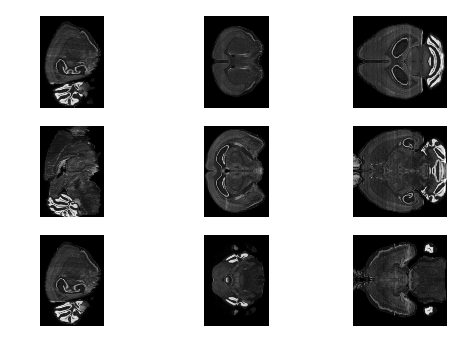

In [2]:
inImg = imgRead("/cis/home/leebc/Projects/Mouse_Histology/figures/for_kwame/atlas.img")
imgShow(inImg)

Next we read the reference image.  The input image will be aligned to this image

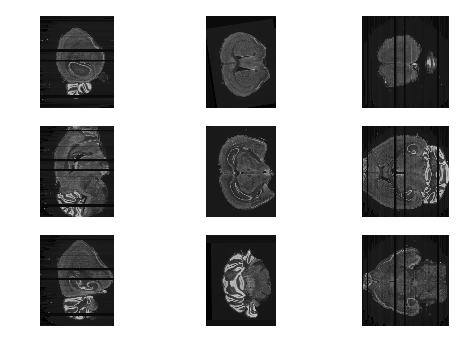

In [3]:
refImg = imgRead("/cis/home/leebc/Projects/Mouse_Histology/figures/for_kwame/target.img")
imgShow(refImg)

## Downsample Images
Ideally we would do resgistration at the full resolution but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images to 0.1 mm x 0.1mm x 0.1mm

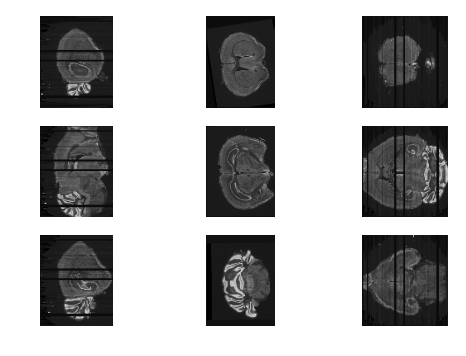

In [4]:
spacing=[0.1,0.1,0.1]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds)

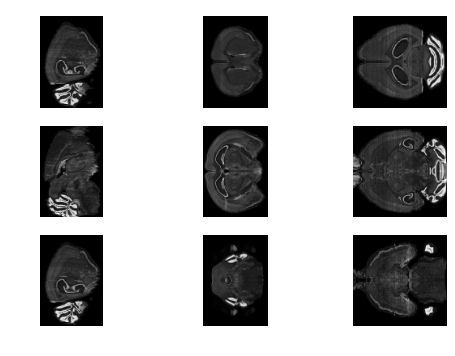

In [5]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds)

## Affine Registration
Now we compute the affine transform.  Here we use *imgAffineComposite* which computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We also use Mutual Information matching and enable the *verbose* option so that each iteration is printed.

In [6]:
affine = imgAffineComposite(inImg_ds, refImg_ds, iterations=100, useMI=True, verbose=True)

Step translation:
0.	 -0.431851241555
1.	 -0.457115379109
2.	 -0.481227945636
3.	 -0.503782474292
4.	 -0.524891183918
5.	 -0.539128433687
6.	 -0.551151239086
7.	 -0.557618829807
8.	 -0.563534123019
9.	 -0.568578834071
10.	 -0.570071738767
11.	 -0.576771578143
12.	 -0.575574256212
13.	 -0.580204307312
14.	 -0.577116497541
15.	 -0.583930604964
16.	 -0.585809984658
17.	 -0.584271006739
18.	 -0.582412004902
19.	 -0.583085614005
20.	 -0.585342411899
21.	 -0.586114376276
22.	 -0.588331408862
23.	 -0.588779100685
24.	 -0.589813053642
25.	 -0.589781308121
26.	 -0.589904622312
27.	 -0.589857532336
28.	 -0.58989924462
29.	 -0.589913677087
Step rigid:
0.	 -0.615408264872
1.	 -0.530698786455
2.	 -0.594800346142
3.	 -0.614379282993
4.	 -0.637108456923
5.	 -0.628291063292
6.	 -0.640267943425
7.	 -0.64070799173
8.	 -0.641024369754
9.	 -0.642189553181
10.	 -0.642256318581
11.	 -0.643009104556
12.	 -0.642866998386
13.	 -0.643514688554
14.	 -0.643429857806
15.	 -0.643915119513
16.	 -0.64396259561
17.	 -

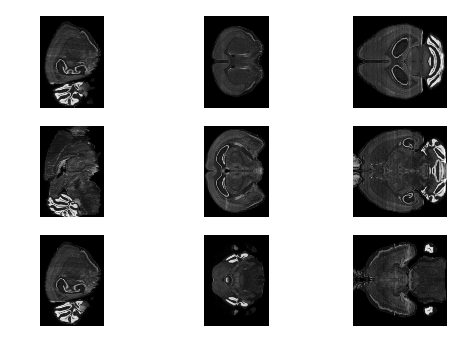

In [7]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg)

# Deformable registration
Now we run LDDMM registration. Here we use imgMetamorphosisComposite which runs LDDMM in multiple steps using the alpha values specified by in alphaList. The field and invField outputs are the composition of all steps. Once agan we use a Mutual Information cost and request verbose output.


Step 0: alpha=0.05, beta=0.05, scale=0.25
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-2.70283e+10, 90.1725, 0, -2.70283e+10 (99.6736%), 1.375000e-04
1.	-2.75799e+10, 173.023, 0, -2.75799e+10 (99.0787%), 1.512500e-04
2.	-2.81863e+10, 273.981, 0, -2.81863e+10 (98.4248%), 1.663750e-04
3.	-2.84641e+10, 312.631, 0, -2.84641e+10 (98.1252%), 9.150625e-05
4.	-2.88684e+10, 357.546, 0, -2.88684e+10 (97.6893%), 1.006569e-04
5.	-2.89488e+10, 425.518, 0, -2.89488e+10 (97.6025%), 1.107226e-04
6.	-2.96471e+10, 496.1, 0, -2.96471e+10 (96.8495%), 1.217948e-04
7.	-2.97112e+10, 572.959, 0, -2.97112e+10 (96.7803%), 1.339743e-04
8.	-2.98088e+10, 628.418, 0, -2.98088e+10 (96.6751%), 7.368587e-05
9.	-2.99975e+10, 671.733, 0, -2.99975e+10 (96.4716%), 8.105445e-05
10.	-3.00481e+10, 679.095, 0, -3.00482e+10 (96.417%), 2.228997e-05
11.	-3.00865e+10, 682.742, 0, -3.00865e+10 (96.3756%), 1.225949e-05
12.	-3.01485e+10, 688.55, 0, -3.01485e+10 (96.3088%), 1.348543e-05
13.	-3.01992e+10, 695.445, 0,

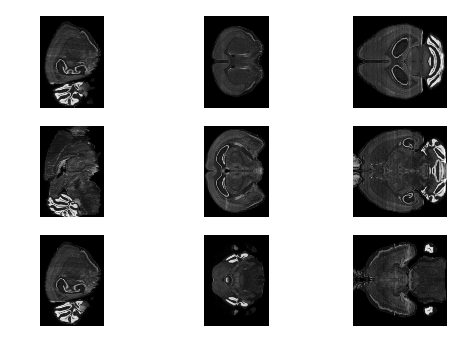

In [8]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, alphaList=[0.05, 0.02, 0.01], scaleList=[0.25, 0.5, 1.0], useMI=True, iterations=100, verbose=True)
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
imgShow(inImg_lddmm)


# Evaluation using checkerboard
We can evaluate the registration by generating a checkerboard of the deformed input and reference image.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

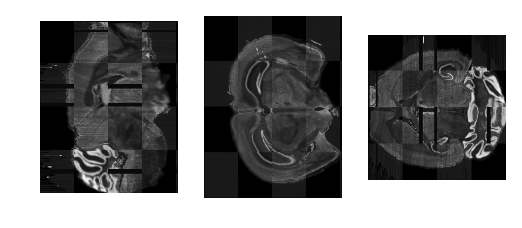

In [10]:
imgShow(imgChecker(inImg_lddmm, refImg, useHM=False), numSlices=1)

In [11]:
imgWrite(inImg_lddmm, "/cis/home/kwame/defAtlas.img")

In [12]:
imgWrite(imgChecker(inImg_lddmm, refImg, useHM=False),"/cis/home/kwame/checker.img")

In [17]:
inAnno = imgRead("/cis/home/leebc/Projects/Mouse_Histology/figures/for_kwame/annotation_40_full_withoutOB_rescaled.img")
inAnno_affine = imgApplyAffine(inAnno, affine, size=refImg.GetSize(), useNearest=True)
inAnno_lddmm = imgApplyField(inAnno_affine, field, size=refImg.GetSize(), useNearest=True)
imgWrite(inAnno_lddmm, "/cis/home/kwame/sharedData/forBrian/defAtlasAnno.img")

In [18]:
imgWrite(field,"/cis/home/kwame/sharedData/forBrian/field.vtk")
imgWrite(invField,"/cis/home/kwame/sharedData/forBrian/invField.vtk")

In [19]:
txtWriteList(affine, "/cis/home/kwame/sharedData/forBrian/affine.tex")